In [428]:
from ilqr.envs import PointMass, Arm
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
import ipdb
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility function

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [703]:
def iLQR(env, iterations=100, 
         reg = 1,                  # initial regularization
         reg_lims = (1e-6, 1e10),  # limtis on regularization
         dreg = 2,                 # reg is multiplied or divided by dreg
         dreg_factor = 1.6,        # dreg is multiplied or diveded by dreg_factor):
         alpha = 1,
         verbose = False,
        ):        

    """
    todo:
    - line search for alpha parameter
    - convergence check
    - control limits (box QP)
    
    fixes:
    - moidfy matrix inversion
    - simpler V updates
    - divergence check
    - add control cost
    - add alpha
    - add reg to V_xx, not Q_xx
    """

    # initial trajectory
    actions = [(0,0) for i in range(env.max_steps)]
    states, costs, costs_derivs = env.rollout(actions)
    state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
    V_x  = costs_derivs[-1]['l_x']
    V_xx = costs_derivs[-1]['l_xx']
    history = dict(cost=[sum(costs)], reg=[reg])
    
    if verbose:
        headers = '{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}'.format(
            'iteration', 'cost', 'dcost', 'expected', 'reg', 'status')
        print(headers, '\n' + ''.join(['-']*len(headers)))

    for i in tqdm(range(iterations)) if not verbose else range(iterations):
        k, K = [], []
        diverged = False
        delta_cost = 0
        dV = 0

        # backward pass
        # (compute new control rules k and K)
        for t in range(env.max_steps-1, -1, -1):
            l, f = costs_derivs[t], state_derivs[t]

            Q_x  = l['l_x']  + f['f_x'].T @ V_x
            Q_u  = l['l_u']  + f['f_u'].T @ V_x
            Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']
            Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
            Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']

            # compute Q_uu inverse
            Q_uu += np.diag([reg]*len(Q_u))
            
            try:
                # cholesky decomposition for matrix inverse
                L = np.linalg.cholesky(Q_uu)
                k.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_u)))
                K.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_ux)))
            except np.linalg.LinAlgError:
                history['cost'].append(sum(costs))
                history['reg'].append(reg)
                
                # abort backward pass
                diverged = True
                flag = 'diverged'
                break

            # update V
            dV  +=   alpha**2*.5 * k[-1].T @ Q_uu @ k[-1] + alpha*k[-1].T @ Q_u  # expected cost reduction
            V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
            V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]

            # check for bad things
            for x in [Q_x, Q_u, Q_xx, Q_uu, Q_ux, Q_uu_inv, V_x, V_xx]:
                if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                    ipdb.set_trace()
        
        if not diverged:
            k.reverse()
            K.reverse()

            # forward pass
            # (compute new trajectory with new control law)
            states_new, costs_new, actions_new = [], [], []
            states_new.append(env.reset(reset_target=False))

            for t in range(env.max_steps):
                action_new = actions[t] + alpha*k[t] + K[t] @ (states_new[-1] - states[t])
                actions_new.append(action_new)
                costs_new.append(env.cost(states_new[-1], actions_new[-1])[0])
                states_new.append(env.step(actions_new[-1]))
            history['cost'].append(sum(costs_new))

            # regularization update
            delta_cost = sum(costs_new) - sum(costs)

            # increase regularization
            if delta_cost>=0:
                dreg = max(dreg_factor, dreg_factor*dreg)
                reg = min(max(reg*dreg, reg_lims[0]), reg_lims[1])
                flag = 'increased'

            # decrease regularization
            else:
                dreg = min(1/dreg_factor, dreg/dreg_factor)
                reg *= dreg * (reg > reg_lims[0])  # latter term sets reg=0 if reg<=reg_lims[0]

                actions = actions_new.copy()
                states = states_new.copy()
                costs = costs_new.copy()
                flag = 'decreased'
                
            history['reg'].append(reg)
        
        if verbose:
            print('{:6d}/{:<5d}{:<12.6f}{:<12.2e}{:<12.2e}{:<12.2e}{:<12s}'.format(
                i, iterations, history['cost'][-1], delta_cost, dV, reg, flag))
    
    return actions, history

# two link arm

iteration   cost        dcost       expected    reg         status       
------------------------------------------------------------------------
     0/10   1.241799    -1.83e+00   -3.60e+00   6.25e-01    decreased   
     1/10   1.241799    0.00e+00    -2.89e+01   6.25e-01    diverged    
     2/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     3/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     4/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     5/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     6/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     7/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     8/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    
     9/10   1.241799    0.00e+00    0.00e+00    6.25e-01    diverged    


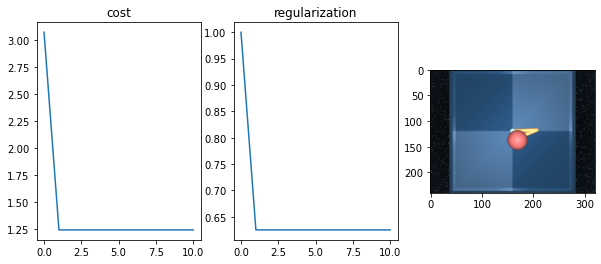

In [712]:
# run ilqr
env = Arm(initial_state=[0,0,0,0])
env.target = [.15,-.15]
actions, history = iLQR(env, iterations=10, reg=1, alpha=1, verbose=True, reg_lims=(1e-6, 1e6))

ax = plt.subplots(1, 3, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');
ax[2].imshow(env.render());

In [713]:
# show video
env.reset(reset_target=False)
imgs = [env.render()]
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))


# point mass

iteration   cost        dcost       expected    reg         status       
------------------------------------------------------------------------
     0/20   1.642801    -1.35e+01   -1.34e+01   6.25e-03    decreased   
     1/20   14.534313   1.29e+01    -1.51e+01   1.00e-02    increased   
     2/20   14.444740   1.28e+01    -1.50e+01   2.56e-02    increased   
     3/20   14.164012   1.25e+01    -1.48e+01   1.05e-01    increased   
     4/20   13.442904   1.18e+01    -1.45e+01   6.87e-01    increased   
     5/20   11.601286   9.96e+00    -1.37e+01   7.21e+00    increased   
     6/20   7.209504    5.57e+00    -1.21e+01   1.21e+02    increased   
     7/20   2.903036    1.26e+00    -8.67e+00   3.25e+03    increased   
     8/20   1.675535    3.27e-02    -2.91e+00   1.39e+05    increased   
     9/20   1.642919    1.18e-04    -4.39e-01   9.58e+06    increased   
    10/20   1.642801    -3.44e-08   -2.59e-02   5.99e+06    decreased   
    11/20   1.642802    9.59e-07    -1.19e-01   9.

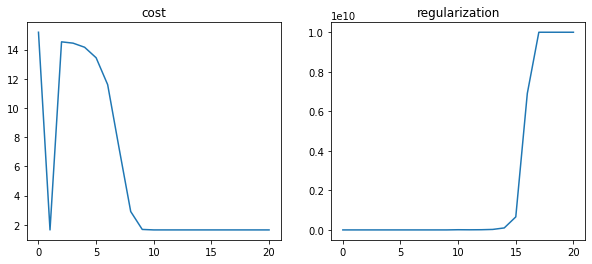

In [710]:
# run ilqr
env = PointMass(max_time=5)
actions, history = iLQR(env, iterations=20, reg=1e-2, verbose=True)
ax = plt.subplots(1,2, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');

In [711]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))